In [12]:
import os

In [13]:
%pwd

'D:\\Pranshu\\Chicken_Disease_Classification'

In [14]:
os.chdir("D:\Pranshu\Chicken_Disease_Classification")

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\prans\AppData\Local\Temp\ipykernel_50996\2106331787.py:1: SyntaxWarning: invalid escape sequence '\P'
  os.chdir("D:\Pranshu\Chicken_Disease_Classification")


In [15]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class PrepareBaseModelConfig:
    root_dir: Path
    base_model_path: Path
    updated_base_model_path: Path
    params_image_size: list
    params_learning_rate: float
    params_include_top: bool
    params_weights: str
    params_classes: int
    params_freeze_all: bool
    params_freeze_till: int

In [16]:
from cnnClassifier.constants import *
from cnnClassifier.utils.common import read_yaml, create_directories

In [17]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])

    def get_prepare_base_model_config(self) -> PrepareBaseModelConfig:
        config = self.config.prepare_base_model
        create_directories([config.root_dir])

        prepare_base_model_config = PrepareBaseModelConfig(
            root_dir = config.root_dir,
            base_model_path = config.base_model_path,
            updated_base_model_path = config.updated_base_model_path,
            params_image_size = self.params.image_size,
            params_learning_rate = self.params.learning_rate,
            params_include_top = self.params.include_top,
            params_weights = self.params.weights,
            params_classes = self.params.classes,
            params_freeze_all = self.params.freeze_all,
            params_freeze_till = self.params.freeze_till 
        )
        return prepare_base_model_config

In [18]:
import os
import urllib.request as request
from zipfile import ZipFile
import tensorflow as tf

In [ ]:
class PrepareBaseModel:
    def __init__(self, config: PrepareBaseModelConfig):
        self.config = config
    
    def get_base_model(self):
        self.model = tf.keras.applications.vgg16.VGG16(
            input_shape=self.config.params_image_size,                              # already (224, 224, 3)       
            include_top=self.config.params_include_top,
            weights=self.config.params_weights
        )

        PrepareBaseModel.save_model(path=self.config.base_model_path, model=self.model)

    @staticmethod
    def _prepare_full_model(model, classes, freeze_all, freeze_till, learning_rate):
        if freeze_all:                                                                  # Freeze all layers by making them untrainable
            for layer in model.layers:
                model.trainable = False
        elif (freeze_till is not None) and (freeze_till > 0):
                for layer in model.layers[:-freeze_till]:
                    model.trainable = False
        flatten_in = tf.keras.layers.Flatten()(model.output)
        predictions = tf.keras.layers.Dense(
                classes, 
                activation='sigmoid'
                )(flatten_in)
        full_model = tf.keras.models.Model(
                inputs=model.input, 
                outputs=predictions)

        full_model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='binary_crossentropy', 
                metrics=['accuracy']
                )
        
        full_model.summary()
        return full_model

    def update_base_model(self):
        self.full_model = self._prepare_full_model(
            model=self.model,
            classes=self.config.params_classes,
            freeze_all=self.config.params_freeze_all,
            freeze_till=self.config.params_freeze_till,
            learning_rate=self.config.params_learning_rate
        )
        
        PrepareBaseModel.save_model(path=self.config.updated_base_model_path, model=self.full_model)      #static method is called using classname.method(). No instance is needed.
    
    def save_model(path: str, model: tf.keras.Model):
        model.save(path)

In [20]:
try:
    config = ConfigurationManager()
    prepare_base_model_config = config.get_prepare_base_model_config()
    prepare_base_model = PrepareBaseModel(config=prepare_base_model_config)
    prepare_base_model.get_base_model()
    prepare_base_model.update_base_model()
except Exception as e:
    raise e

[2025-05-25 15:44:09,423: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-05-25 15:44:09,425: INFO: common: yaml file: params.yaml loaded successfully]
[2025-05-25 15:44:09,426: INFO: common: created directory at: artifacts]
[2025-05-25 15:44:09,427: INFO: common: created directory at: artifacts/prepare_base_model]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │        50,178 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,764,866 (56.32 MB)

 Trainable params: 50,178 (196.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

d:\Pranshu\Chicken_Disease_Classification\chicken_disease\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


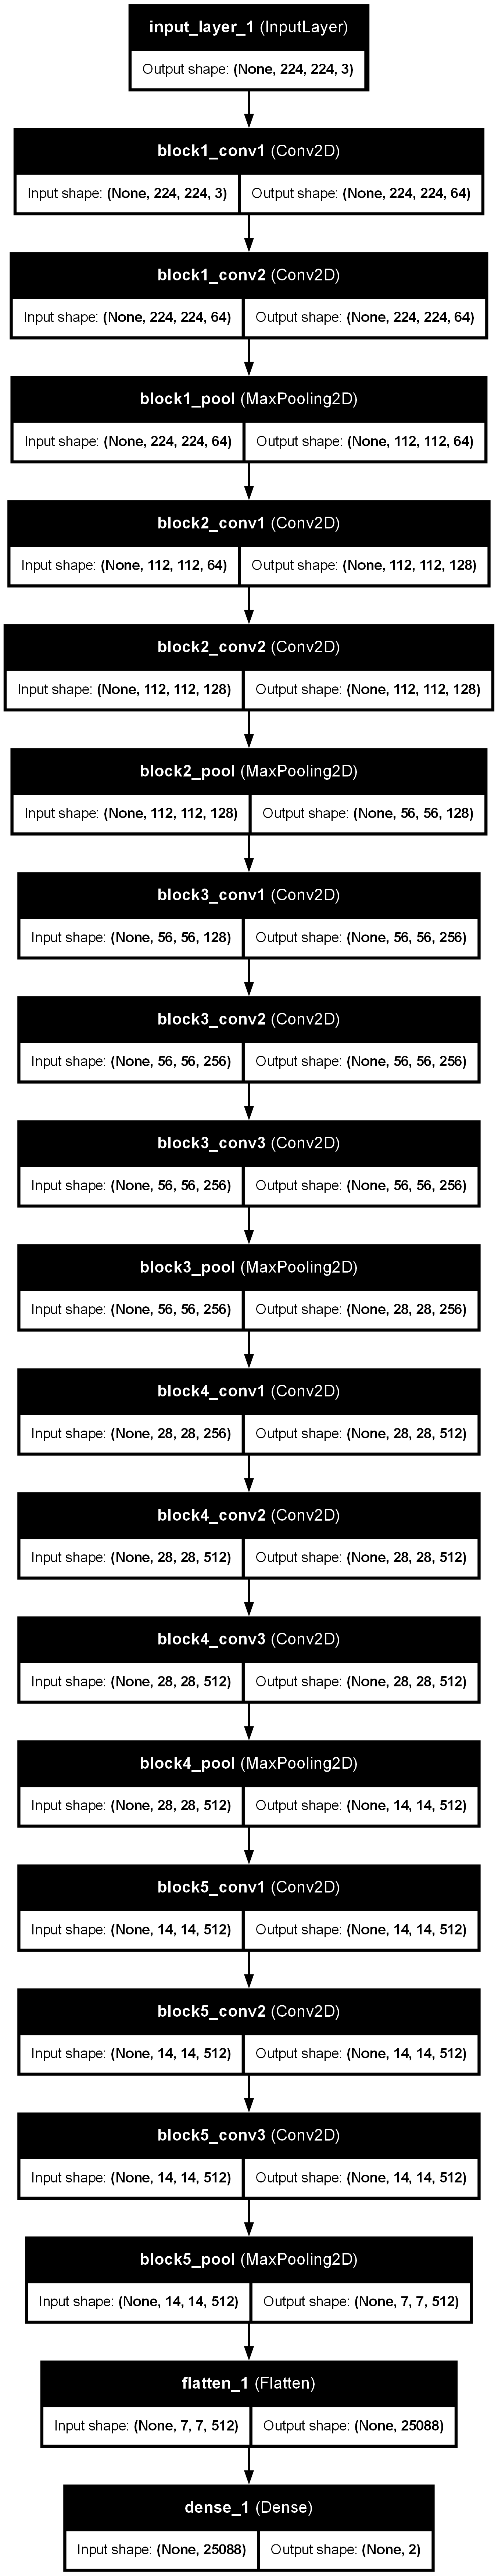

In [22]:
model = load_model("artifacts/prepare_base_model/base_model_updated.keras")
plot_model(
    model=model,
    to_file=r"D:\Pranshu\Chicken_Disease_Classification\artifacts\prepare_base_model\model_visualization.png",
    show_shapes=True,
    show_layer_names=True
)